## code to produce figure 5, feedbacks

originally in scratch/BOE-SOcarbon/contribution-timeseries.ipynb

In [161]:
import numpy as np

In [162]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import matplotlib.gridspec as gridspec


In [163]:
yrs = np.arange(1950,2100,1)

In [164]:
def effect_SST(sst_delta, R, DIC, pCO2):
    
    dpCO2 = 0.04*pCO2*sst_delta
    delDIC = (DIC/pCO2) * dpCO2/R
    
    #for a positive increase in sst, positive DIC
    dDIC_T = 1 *delDIC
    return dDIC_T
    
def effect_MLD(mld_delta, grad_dDICdz,\
                grad_dFedz, dmudFe, mu_L, diatconc, efratio):
    #dic
    dDIC_MLD = mld_delta*grad_dDICdz #dDIC = dMLD x dDIC/dz, umol/L
    #iron (ecosystem)
    dFe = mld_delta *  grad_dFedz #dFe = dMLD x dFe/dz 
    #print(dFe)
    dBioDIC_MLD = -1 * dmudFe * dFe * mu_L * diatconc * 365.25 * efratio #dDIC = -dmu/dFe x dFe x mu_L x DIA x dtime  
    
    return dDIC_MLD, dBioDIC_MLD



def effect_OT(ot_delta,grad_DIC_surfdeep, dmudFe, grad_dFev, mu_L, \
              diatconc, MLD, efratio = 0.5, SO_area = 4.67e13 ):

    dDIC_OT = ot_delta * 1e6 * grad_DIC_surfdeep / 1000*31557600    ## in mols to surface
    
    #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dDICv = -dmudFe* grad_dFev * mu_L * diatconc * 365.25 * efratio #dDICv = -dmu/dFe x dFev x mu_L x DIA x dtime 
    dBioDIC_OT = dDICv * ot_delta * 1e6 * 1000*31557600*0.000001 #in mols extra DIC to surface    
    dDIC_OT = dDIC_OT/SO_area/MLD*1000
    dBioDIC_OT = dBioDIC_OT/SO_area/MLD*1000 ## mmols/m3 at surface
    
    return dDIC_OT, dBioDIC_OT


## xx ukesm SST, MLD, OT, CFLX trends


In [165]:
sst_ukesm_1A = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/SST_ukesm_1A.nc')
sst_ukesm_1B = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/SST_ukesm_1B.nc')

mld_ukesm_1A = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1A.nc')
mld_ukesm_1B = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/somxl010_ukesm_1B.nc')

Cflx_ukesm_1A = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/CflxTS_ukesm_1A_SO.nc')
Cflx_ukesm_1B = xr.open_dataset(f'../SOZONE/windAnalyis/oceanFields/extracted-summary/CflxTS_ukesm_1B_SO.nc')

def make_yearlist(yrst, yrend, tscen, \
                  tdir = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/oceanFields/max_OT_s50/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]
        ty = f'{tdir}/seas_OT_{yr}_{tscen}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

ot_ukesm_1A = xr.open_mfdataset(make_yearlist(1950,2099,'1A'))
ot_ukesm_1B = xr.open_mfdataset(make_yearlist(1950,2099,'1B'))

In [166]:
sst_1A = sst_ukesm_1A.tos.groupby('time_counter.year').mean().values
sst_1B = sst_ukesm_1B.tos.groupby('time_counter.year').mean().values
mld_1A = mld_ukesm_1A.somxl010.groupby('time_counter.year').mean().values
mld_1B = mld_ukesm_1B.somxl010.groupby('time_counter.year').mean().values
ot_1A = ot_ukesm_1A.max_OT_yr.groupby('time_counter.year').mean().values
ot_1B = ot_ukesm_1B.max_OT_yr.groupby('time_counter.year').mean().values

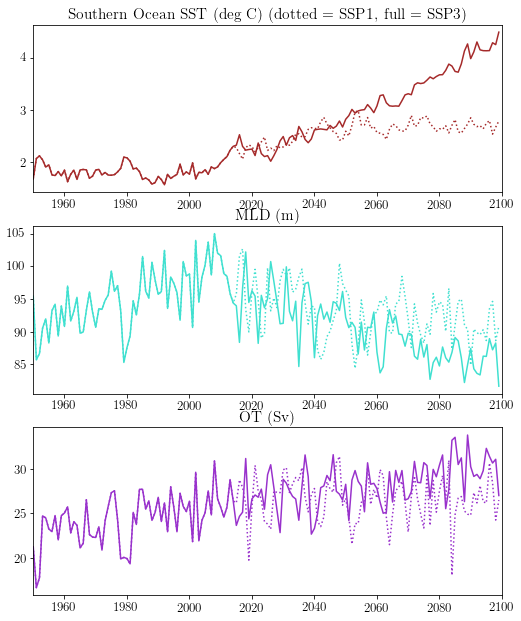

In [167]:
sst_col = 'brown'
mld_col = 'turquoise'
ot_col = 'darkorchid'
eco_col = 'limegreen'

fact = 0.7
fig, axs = plt.subplots(3,1, figsize=(12*fact, 15*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs,sst_1A, linestyle = ':', color = sst_col)
axs[0].plot(yrs,sst_1B, linestyle = '-', color = sst_col)

axs[1].plot(yrs,mld_1A, linestyle = ':', color = mld_col)
axs[1].plot(yrs,mld_1B, linestyle = '-', color = mld_col)

axs[2].plot(yrs,ot_1A, linestyle = ':', color = ot_col)
axs[2].plot(yrs,ot_1B, linestyle = '-', color = ot_col)


tits = ['Southern Ocean SST (deg C) (dotted = SSP1, full = SSP3)',
       'MLD (m)',\
       'OT (Sv)']
for i in range(0,3):
    axs[i].set_title(tits[i])
    axs[i].set_xlim([1950,2100])

##xx  glodap and medusa carbonate chemistry

xx - how and where calculated?

In [168]:
def make_yearlist_glodap_cchem(scen):
    yrs = np.arange(1950,2100,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data-cchem/cchem-param-glodap_sdp_scen-{scen}-{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def make_yearlist_medusa_cchem(scen):
    yrs = np.arange(1950,2100,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'./data-cchem/cchem-param-medusa_scen-{scen}-{yrs[i]}.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

glodap_cchem_1A = xr.open_mfdataset(make_yearlist_glodap_cchem('1A'))
glodap_cchem_1B = xr.open_mfdataset(make_yearlist_glodap_cchem('1B'))
medusa_cchem_1A = xr.open_mfdataset(make_yearlist_medusa_cchem('1A'))
medusa_cchem_1B = xr.open_mfdataset(make_yearlist_medusa_cchem('1B'))




In [169]:
glodap_DIC_1A = glodap_cchem_1A.mn_DIC.groupby('time_counter.year').mean().values[:,0]
glodap_DIC_1B = glodap_cchem_1B.mn_DIC.groupby('time_counter.year').mean().values[:,0]
medusa_DIC_1A = medusa_cchem_1A.mn_DIC.groupby('time_counter.year').mean().values[:,0]
medusa_DIC_1B = medusa_cchem_1B.mn_DIC.groupby('time_counter.year').mean().values[:,0]

glodap_TA_1A = glodap_cchem_1A.mn_TA.groupby('time_counter.year').mean().values[:,0]
glodap_TA_1B = glodap_cchem_1B.mn_TA.groupby('time_counter.year').mean().values[:,0]
medusa_TA_1A = medusa_cchem_1A.mn_TA.groupby('time_counter.year').mean().values[:,0]
medusa_TA_1B = medusa_cchem_1B.mn_TA.groupby('time_counter.year').mean().values[:,0]

glodap_dDICdz_1A = glodap_cchem_1A.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]
glodap_dDICdz_1B = glodap_cchem_1B.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]
medusa_dDICdz_1A = medusa_cchem_1A.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]
medusa_dDICdz_1B = medusa_cchem_1B.grad_dDICdz.groupby('time_counter.year').mean().values[:,0]

glodap_dDICsd_1A = glodap_cchem_1A.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]
glodap_dDICsd_1B = glodap_cchem_1B.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]
medusa_dDICsd_1A = medusa_cchem_1A.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]
medusa_dDICsd_1B = medusa_cchem_1B.grad_DIC_surfdeep.groupby('time_counter.year').mean().values[:,0]

glodap_Revfact_1A = glodap_cchem_1A.mn_Revfact.groupby('time_counter.year').mean().values[:,0]
glodap_Revfact_1B = glodap_cchem_1B.mn_Revfact.groupby('time_counter.year').mean().values[:,0]
medusa_Revfact_1A = medusa_cchem_1A.mn_Revfact.groupby('time_counter.year').mean().values[:,0]
medusa_Revfact_1B = medusa_cchem_1B.mn_Revfact.groupby('time_counter.year').mean().values[:,0]

glodap_pCO2_1A = glodap_cchem_1A.mn_pCO2.groupby('time_counter.year').mean().values[:,0]
glodap_pCO2_1B = glodap_cchem_1B.mn_pCO2.groupby('time_counter.year').mean().values[:,0]
medusa_pCO2_1A = medusa_cchem_1A.mn_pCO2.groupby('time_counter.year').mean().values[:,0]
medusa_pCO2_1B = medusa_cchem_1B.mn_pCO2.groupby('time_counter.year').mean().values[:,0]

## xx- biology

In [170]:
def make_yearlist_bio(yrst, yrend, scen):

    tdir = './data-cchem/'
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        yr = yrs[i]

        t2 = glob.glob(f'{tdir}biol-param-medusa_scen-{scen}-{yr}.nc')
        ylist.append(t2[0])
        
    return ylist

    
medusa_bio_1A = xr.open_mfdataset(make_yearlist_bio(1950,2099,'1A'))
medusa_bio_1B = xr.open_mfdataset(make_yearlist_bio(1950,2099,'1B'))

w = xr.open_dataset('./data-cchem/BOE-inputs/BOE-INPUT-OBS.nc')

In [171]:
medusa_dFedz_1A = medusa_bio_1A.dmudFe.groupby('time_counter.year').mean().values[:,0]
medusa_dFedz_1B = medusa_bio_1B.dmudFe.groupby('time_counter.year').mean().values[:,0]

medusa_diat_1A = medusa_bio_1A.diatconc.groupby('time_counter.year').mean().values[:,0]
medusa_diat_1B = medusa_bio_1B.diatconc.groupby('time_counter.year').mean().values[:,0]

medusa_dFesd_1A = medusa_bio_1A.grad_dFev.groupby('time_counter.year').mean().values[:,0]
medusa_dFesd_1B = medusa_bio_1B.grad_dFev.groupby('time_counter.year').mean().values[:,0]

glodap_dFedz_1A = np.zeros_like(medusa_dFedz_1A)
glodap_dFedz_1A[:] = 0.000528
glodap_dFedz_1B = np.zeros_like(medusa_dFedz_1A)
glodap_dFedz_1B[:] = 0.000528

glodap_diat_1A = np.zeros_like(medusa_dFedz_1A)
glodap_diat_1A[:] = 1.59675
glodap_diat_1B = np.zeros_like(medusa_dFedz_1A)
glodap_diat_1B[:] = 1.59675

glodap_dFesd_1A = np.zeros_like(medusa_dFedz_1A)
glodap_dFesd_1A[:]= 0.226392
glodap_dFesd_1B = np.zeros_like(medusa_dFedz_1A)
glodap_dFesd_1B[:]= 0.226392



## plot changes in cchem/biology in model and obs

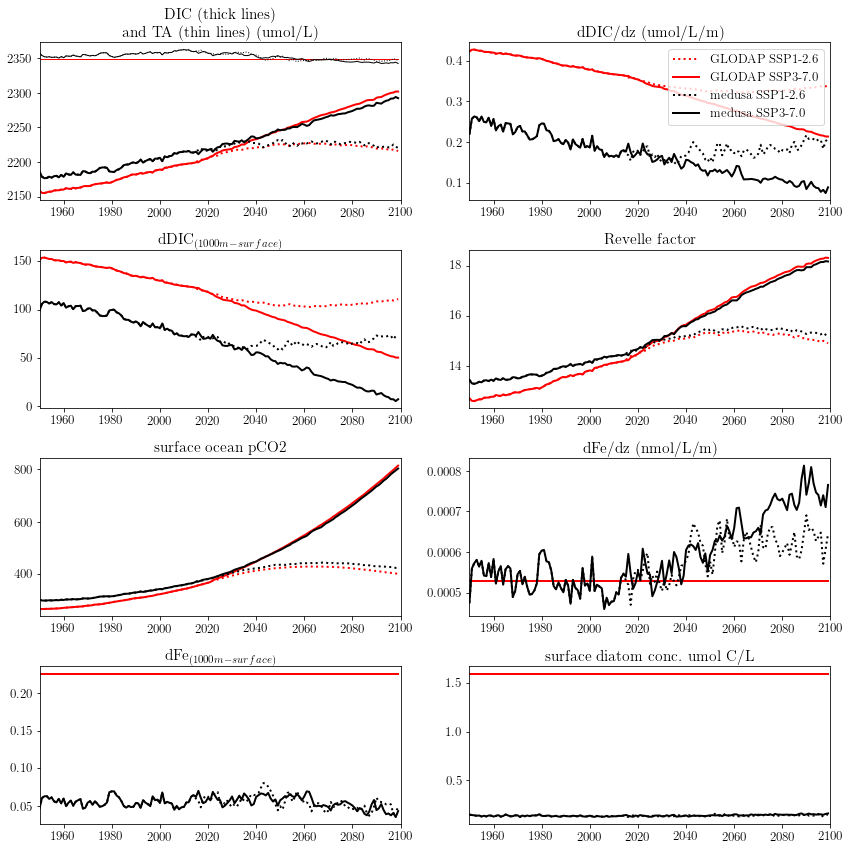

In [172]:

fact = 1

fig, axs = plt.subplots(4,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrs, glodap_DIC_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[0].plot(yrs, glodap_DIC_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[0].plot(yrs, glodap_TA_1A, 'r:', linewidth = 1, label = 'GLODAP SSP1-2.6 (TA)')
axs[0].plot(yrs, glodap_TA_1B, 'r-', linewidth = 1, label = 'GLODAP SSP3-7.0 (TA)')

axs[0].plot(yrs, medusa_DIC_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[0].plot(yrs, medusa_DIC_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')
axs[0].plot(yrs, medusa_TA_1A, 'k:', linewidth = 1, label = 'medusa SSP1-2.6 (TA)')
axs[0].plot(yrs, medusa_TA_1B, 'k-', linewidth = 1, label = 'medusa SSP3-7.0 (TA)')

ind = 1
axs[ind].plot(yrs, glodap_dDICdz_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dDICdz_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dDICdz_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dDICdz_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 2
axs[ind].plot(yrs, glodap_dDICsd_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dDICsd_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dDICsd_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dDICsd_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 3
axs[ind].plot(yrs, glodap_Revfact_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_Revfact_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_Revfact_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_Revfact_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 4
axs[ind].plot(yrs, glodap_pCO2_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_pCO2_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_pCO2_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_pCO2_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 5
axs[ind].plot(yrs, glodap_dFedz_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dFedz_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dFedz_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dFedz_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 6
axs[ind].plot(yrs, glodap_dFesd_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_dFesd_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_dFesd_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_dFesd_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

ind = 7
axs[ind].plot(yrs, glodap_diat_1A, 'r:', linewidth = 2, label = 'GLODAP SSP1-2.6')
axs[ind].plot(yrs, glodap_diat_1B, 'r-', linewidth = 2, label = 'GLODAP SSP3-7.0')
axs[ind].plot(yrs, medusa_diat_1A, 'k:', linewidth = 2, label = 'medusa SSP1-2.6')
axs[ind].plot(yrs, medusa_diat_1B, 'k-', linewidth = 2, label = 'medusa SSP3-7.0')

axs[1].legend(loc = 'best')

tits = ['DIC (thick lines) \n and TA (thin lines) (umol/L)',
       'dDIC/dz (umol/L/m)', 'dDIC$_{(1000m-surface)}$',\
       'Revelle factor', 'surface ocean pCO2', 'dFe/dz (nmol/L/m)', \
       'dFe$_{(1000m-surface)}$', 'surface diatom conc. umol C/L']
for i in range(0,8):
    axs[i].set_title(tits[i])
    axs[i].set_xlim([1950,2100])
    
    
plt.tight_layout()

## ok now the effects

In [173]:
def get_effects(T_ts, RevelleFact, DIC, pco2,\
               MLD_ts, grad_DIC_MLD, grad_fe_MLD, diat, \
               OT_ts,  grad_DIC_OT, grad_fe_OT):

    #constants
    efratio = 0.5
    dmudFe = 0.59; 
    muL = 0.438275
    ##initialize
    ts_OT_effect = np.zeros_like(pco2)
    ts_MLD_effect = np.zeros_like(pco2)
    ts_T_effect = np.zeros_like(pco2)
    ts_ECO_effect = np.zeros_like(pco2)
    ts_DIC_effect = np.zeros_like(pco2)

    ts_OT_effect_cum = np.zeros_like(pco2)
    ts_MLD_effect_cum = np.zeros_like(pco2)
    ts_T_effect_cum = np.zeros_like(pco2)
    ts_ECO_effect_cum = np.zeros_like(pco2)
    ts_DIC_effect_cum = np.zeros_like(pco2)


    for i in range(1,150):

        sst_delta = T_ts[i]-T_ts[i-1]
        dDIC_T = effect_SST(sst_delta, RevelleFact[i-1], DIC[i-1], pco2[i-1])
        ts_T_effect[i] = dDIC_T

        mld_delta = MLD_ts[i] - MLD_ts[i-1] 
        diatconc = diat[i-1]
        
        dDIC_MLD, dBioDIC_MLD = effect_MLD(mld_delta, grad_DIC_MLD[i-1],\
                    grad_fe_MLD[i-1], dmudFe, muL, diatconc, efratio)
        ts_MLD_effect[i] = dDIC_MLD

        ot_delta = OT_ts[i] - OT_ts[i-1]
        dDIC_OT, dBioDIC_OT = effect_OT(ot_delta,grad_DIC_OT[i-1], \
                                    dmudFe, grad_fe_OT[i-1], muL, \
                  diatconc, MLD_ts[i], efratio, SO_area = 4.67e13 )
        
        ts_OT_effect[i] = dDIC_OT
        ts_ECO_effect[i] = dBioDIC_MLD + dBioDIC_OT
        ts_DIC_effect[i] = DIC[i] - DIC[i-1]

    for i in range(1,150):

        ts_T_effect_cum[i] = ts_T_effect[i] + ts_T_effect_cum[i-1]
        ts_MLD_effect_cum[i] = ts_MLD_effect[i] + ts_MLD_effect_cum[i-1]
        ts_OT_effect_cum[i] = ts_OT_effect[i] + ts_OT_effect_cum[i-1]
        ts_ECO_effect_cum[i] = ts_ECO_effect[i] + ts_ECO_effect_cum[i-1]
        ts_DIC_effect_cum[i] = ts_DIC_effect[i] + ts_DIC_effect_cum[i-1]

    return ts_T_effect, ts_MLD_effect, ts_OT_effect, ts_ECO_effect, ts_DIC_effect,\
    ts_T_effect_cum, ts_MLD_effect_cum, ts_OT_effect_cum, ts_ECO_effect_cum, ts_DIC_effect_cum






### helper functions (moving avg, etc)

In [174]:
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ma = ret[n - 1:] / n
    return ma


def pad_avg(a, sot = 1950, n=10):
    
    arr_no_nans = np.nan_to_num(a, nan=0.0)
    aret = np.zeros_like(arr_no_nans)
    aret[:] = np.nan
    ma = moving_average(arr_no_nans)
    st = int(n/2)
    en = len(ma) + st
    aret[st:en] = ma
    aret[0:sot-1950] = np.nan
    
    return aret



## get effect sizes for glodap, glodapvul (exaggerated TS) and medusa

In [175]:
ts_T_effect_glodap_1A, ts_MLD_effect_glodap_1A, ts_OT_effect_glodap_1A,\
ts_ECO_effect_glodap_1A, ts_DIC_effect_glodap_1A,\
ts_T_effect_glodap_1A_cum, ts_MLD_effect_glodap_1A_cum,\
ts_OT_effect_glodap_1A_cum, ts_ECO_effect_glodap_1A_cum, ts_DIC_effect_glodap_1A_cum = \
get_effects(sst_1A, glodap_Revfact_1A, glodap_DIC_1A, glodap_pCO2_1A,\
mld_1A, glodap_dDICdz_1A, glodap_dFedz_1A, glodap_diat_1A, \
ot_1A,  glodap_dDICsd_1A, glodap_dFesd_1A)


ts_T_effect_glodap_1B, ts_MLD_effect_glodap_1B, ts_OT_effect_glodap_1B,\
ts_ECO_effect_glodap_1B, ts_DIC_effect_glodap_1B,\
ts_T_effect_glodap_1B_cum, ts_MLD_effect_glodap_1B_cum,\
ts_OT_effect_glodap_1B_cum, ts_ECO_effect_glodap_1B_cum, ts_DIC_effect_glodap_1B_cum = \
get_effects(sst_1B, glodap_Revfact_1B, glodap_DIC_1B, glodap_pCO2_1B,\
mld_1B, glodap_dDICdz_1B, glodap_dFedz_1B, glodap_diat_1B, \
ot_1B,  glodap_dDICsd_1B, glodap_dFesd_1B)

ts_T_effect_medusa_1A, ts_MLD_effect_medusa_1A, ts_OT_effect_medusa_1A,\
ts_ECO_effect_medusa_1A, ts_DIC_effect_medusa_1A,\
ts_T_effect_medusa_1A_cum, ts_MLD_effect_medusa_1A_cum,\
ts_OT_effect_medusa_1A_cum, ts_ECO_effect_medusa_1A_cum, ts_DIC_effect_medusa_1A_cum = \
get_effects(sst_1A, medusa_Revfact_1A, medusa_DIC_1A, medusa_pCO2_1A,\
mld_1A, medusa_dDICdz_1A, medusa_dFedz_1A, medusa_diat_1A, \
ot_1A,  medusa_dDICsd_1A, medusa_dFesd_1A)


ts_T_effect_medusa_1B, ts_MLD_effect_medusa_1B, ts_OT_effect_medusa_1B,\
ts_ECO_effect_medusa_1B, ts_DIC_effect_medusa_1B,\
ts_T_effect_medusa_1B_cum, ts_MLD_effect_medusa_1B_cum,\
ts_OT_effect_medusa_1B_cum, ts_ECO_effect_medusa_1B_cum, ts_DIC_effect_medusa_1B_cum = \
get_effects(sst_1B, medusa_Revfact_1B, medusa_DIC_1B, medusa_pCO2_1B,\
mld_1B, medusa_dDICdz_1B, medusa_dFedz_1B, medusa_diat_1B, \
ot_1B,  medusa_dDICsd_1B, medusa_dFesd_1B)

ts_T_effect_glodapvul_1A, ts_MLD_effect_glodapvul_1A, ts_OT_effect_glodapvul_1A,\
ts_ECO_effect_glodapvul_1A, ts_DIC_effect_glodapvul_1A,\
ts_T_effect_glodapvul_1A_cum, ts_MLD_effect_glodapvul_1A_cum,\
ts_OT_effect_glodapvul_1A_cum, ts_ECO_effect_glodapvul_1A_cum, ts_DIC_effect_glodapvul_1A_cum = \
get_effects(sst_1A, glodap_Revfact_1A, glodap_DIC_1A, glodap_pCO2_1A,\
mld_1A, glodap_dDICdz_1A*2, glodap_dFedz_1A, glodap_diat_1A, \
ot_1A,  glodap_dDICsd_1A+100, glodap_dFesd_1A)


ts_T_effect_glodapvul_1B, ts_MLD_effect_glodapvul_1B, ts_OT_effect_glodapvul_1B,\
ts_ECO_effect_glodapvul_1B, ts_DIC_effect_glodapvul_1B,\
ts_T_effect_glodapvul_1B_cum, ts_MLD_effect_glodapvul_1B_cum,\
ts_OT_effect_glodapvul_1B_cum, ts_ECO_effect_glodapvul_1B_cum, ts_DIC_effect_glodapvul_1B_cum = \
get_effects(sst_1B, glodap_Revfact_1B, glodap_DIC_1B, glodap_pCO2_1B,\
mld_1B, glodap_dDICdz_1B*2, glodap_dFedz_1B, glodap_diat_1B, \
ot_1B,  glodap_dDICsd_1B+100, glodap_dFesd_1B)


## exploring DIC/temperature feedbacks

In [176]:
sst_1A_eff = np.zeros_like(sst_1A)
sst_1B_eff = np.zeros_like(sst_1B)
sst_1A_eff_cum = np.zeros_like(sst_1A)
sst_1B_eff_cum = np.zeros_like(sst_1B)

for i in range(1,150):

    sst_1A_eff[i] = sst_1A[i]-sst_1A[i-1]
    sst_1B_eff[i] = sst_1B[i]-sst_1B[i-1]
    
for i in range(1,150):

    sst_1A_eff_cum[i] = sst_1A_eff[i] + sst_1A_eff_cum[i-1]
    sst_1B_eff_cum[i] = sst_1B_eff[i] + sst_1B_eff_cum[i-1]
    
# plt.plot()

## paper figures: feedback (with feedback/SST as well)

### colours for plot

In [177]:
sot = 2015

sst_col = '#de4231'#'#e6194B'#'r'
ot_col = '#01529b'#'#9A6324'#'#37323d'#'#2c3438'
mld_col = '#6db8ff'#'#4363d8'#'b'#'#34abeb'
eco_col = '#02954f'#'#66b54c'#'#5f8a1e'
tot_col = '#f3c108'


## version of fig5 for paper (we have 

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:127: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:131: Ru

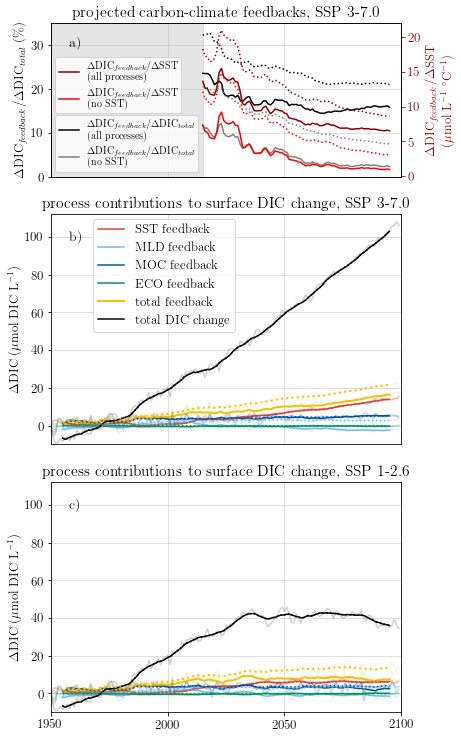

In [178]:
ymi = 0; yma = 26
addmed = True #medusa on plot?
if addmed:
    ymi = 0; yma = 35

fact = 0.95
# Create a figure
fig = plt.figure(figsize=(7*fact, 11*fact))

# Create a GridSpec with 3 rows and 1 column
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 3, 3])

# Add subplots using the GridSpec layout
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[2, 0])

# Set titles for each subplot for clarity
###

ax3.plot(yrs, ts_T_effect_glodap_1B_cum, color = sst_col, alpha = 0.2)
ax3.plot(yrs, pad_avg(ts_T_effect_glodap_1B_cum), color = sst_col, label = 'SST feedback')
ax3.plot(yrs, ts_MLD_effect_glodap_1B_cum, color = mld_col, alpha = 0.2)
ax3.plot(yrs, pad_avg(ts_MLD_effect_glodap_1B_cum), color = mld_col, label = 'MLD feedback')
ax3.plot(yrs, ts_OT_effect_glodap_1B_cum, color = ot_col, alpha = 0.2 )
ax3.plot(yrs, pad_avg(ts_OT_effect_glodap_1B_cum), color = ot_col, label = 'MOC feedback')
ax3.plot(yrs, ts_ECO_effect_glodap_1B_cum, color = eco_col, alpha = 0.2 )
ax3.plot(yrs, pad_avg(ts_ECO_effect_glodap_1B_cum), color = eco_col, label = 'ECO feedback')
ts_tot_effect_1B_cum_glodap = ts_T_effect_glodap_1B_cum + ts_MLD_effect_glodap_1B_cum + \
ts_OT_effect_glodap_1B_cum + ts_ECO_effect_glodap_1B_cum
ts_tot_effect_1B_nosst_glodap = ts_MLD_effect_glodap_1B_cum + \
ts_OT_effect_glodap_1B_cum + ts_ECO_effect_glodap_1B_cum

ax3.plot(yrs, ts_tot_effect_1B_cum_glodap, color = tot_col, alpha = 0.2, linewidth = 1)
ax3.plot(yrs, pad_avg(ts_tot_effect_1B_cum_glodap), color = tot_col, linewidth = 2, label = 'total feedback')
ax3.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax3.plot(yrs, pad_avg(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'total DIC change')

if addmed:
    ax3.plot(yrs, ts_T_effect_medusa_1B_cum, color = sst_col, alpha = 0.2)
    ax3.plot(yrs, pad_avg(ts_T_effect_medusa_1B_cum), color = sst_col, linestyle = ':')
    ax3.plot(yrs, ts_MLD_effect_medusa_1B_cum, color = mld_col, alpha = 0.2)
    ax3.plot(yrs, pad_avg(ts_MLD_effect_medusa_1B_cum), color = mld_col, linestyle = ':')
    ax3.plot(yrs, ts_OT_effect_medusa_1B_cum, color = ot_col, alpha = 0.2 )
    ax3.plot(yrs, pad_avg(ts_OT_effect_medusa_1B_cum), color = ot_col, linestyle = ':')
    ax3.plot(yrs, ts_ECO_effect_medusa_1B_cum, color = eco_col, alpha = 0.2 )
    ax3.plot(yrs, pad_avg(ts_ECO_effect_medusa_1B_cum), color = eco_col, linestyle = ':')
    ts_tot_effect_1B_cum_medusa = ts_T_effect_medusa_1B_cum + ts_MLD_effect_medusa_1B_cum + \
    ts_OT_effect_medusa_1B_cum + ts_ECO_effect_medusa_1B_cum
    ts_tot_effect_1B_nosst_medusa = ts_MLD_effect_medusa_1B_cum + \
    ts_OT_effect_medusa_1B_cum + ts_ECO_effect_medusa_1B_cum

    ax3.plot(yrs, ts_tot_effect_1B_cum_medusa, color = tot_col, alpha = 0.2, linewidth = 1)
    ax3.plot(yrs, pad_avg(ts_tot_effect_1B_cum_medusa), color = tot_col, linewidth = 2, linestyle = ':')
    ax3.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
    ax3.plot(yrs, pad_avg(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, linestyle = ':')


ax5.plot(yrs, ts_T_effect_glodap_1A_cum, color = sst_col, alpha = 0.2)
ax5.plot(yrs, pad_avg(ts_T_effect_glodap_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax5.plot(yrs, ts_MLD_effect_glodap_1A_cum, color = mld_col, alpha = 0.2)
ax5.plot(yrs, pad_avg(ts_MLD_effect_glodap_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax5.plot(yrs, ts_OT_effect_glodap_1A_cum, color = ot_col, alpha = 0.2 )
ax5.plot(yrs, pad_avg(ts_OT_effect_glodap_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax5.plot(yrs, ts_ECO_effect_glodap_1A_cum, color = eco_col, alpha = 0.2 )
ax5.plot(yrs, pad_avg(ts_ECO_effect_glodap_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_glodap_1A_cum + ts_MLD_effect_glodap_1A_cum + \
ts_OT_effect_glodap_1A_cum + ts_ECO_effect_glodap_1A_cum
ax5.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax5.plot(yrs, pad_avg(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax5.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax5.plot(yrs, pad_avg(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')

if addmed:
    ax5.plot(yrs, ts_T_effect_medusa_1A_cum, color = sst_col, alpha = 0.2)
    ax5.plot(yrs, pad_avg(ts_T_effect_medusa_1A_cum), color = sst_col, linestyle = ':')
    ax5.plot(yrs, ts_MLD_effect_medusa_1A_cum, color = mld_col, alpha = 0.2)
    ax5.plot(yrs, pad_avg(ts_MLD_effect_medusa_1A_cum), color = mld_col, linestyle = ':')
    ax5.plot(yrs, ts_OT_effect_medusa_1A_cum, color = ot_col, alpha = 0.2 )
    ax5.plot(yrs, pad_avg(ts_OT_effect_medusa_1A_cum), color = ot_col, linestyle = ':')
    ax5.plot(yrs, ts_ECO_effect_medusa_1A_cum, color = eco_col, alpha = 0.2 )
    ax5.plot(yrs, pad_avg(ts_ECO_effect_medusa_1A_cum), color = eco_col, linestyle = ':')
    ts_tot_effect_1A_cum_medusa = ts_T_effect_medusa_1A_cum + ts_MLD_effect_medusa_1A_cum + \
    ts_OT_effect_medusa_1A_cum + ts_ECO_effect_medusa_1A_cum
    ts_tot_effect_1A_nosst_medusa = ts_MLD_effect_medusa_1A_cum + \
    ts_OT_effect_medusa_1A_cum + ts_ECO_effect_medusa_1A_cum

    ax5.plot(yrs, ts_tot_effect_1A_cum_medusa, color = tot_col, alpha = 0.2, linewidth = 1)
    ax5.plot(yrs, pad_avg(ts_tot_effect_1A_cum_medusa), color = tot_col, linewidth = 2, linestyle = ':')
    ax5.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  )
    ax5.plot(yrs, pad_avg(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, linestyle = ':')


####### code for proportions!!!
glodap_prop = ts_tot_effect_1B_cum_glodap/ts_DIC_effect_medusa_1B_cum
glodap_propc = pad_avg(glodap_prop,sot)*100
ax1.plot(yrs,glodap_propc, color = 'k', label = '$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ \n (all processes)')
glodap_nosst_prop = ts_tot_effect_1B_nosst_glodap/ts_DIC_effect_medusa_1B_cum
glodap_nosst_propc = pad_avg(glodap_nosst_prop,sot)*100
ax1.plot(yrs,glodap_nosst_propc, color = 'grey', label = '$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ \n (no SST)')


axs1b = ax1.twinx()
dicpert = ts_tot_effect_1B_cum_glodap/sst_1B_eff_cum
dicpertc = pad_avg(dicpert,sot)
ax1.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax1.set_ylim([ymi,yma])
axs1b.plot(yrs,dicpertc, color ='darkred',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (all processes)')

dicpert_nosst = ts_tot_effect_1B_nosst_glodap/sst_1B_eff_cum
dicpertcs = pad_avg(dicpert_nosst,sot)
ax1.set_ylim([ymi,yma])
axs1b.plot(yrs,dicpertcs, color ='red',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (no SST)')



#axs1b.set_ylim([35,100])
axs1b.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs1b.tick_params(axis='y', colors='darkred')
axs1b.yaxis.label.set_color('darkred')


if addmed:
    medusa_prop = ts_tot_effect_1B_cum_medusa/ts_DIC_effect_medusa_1B_cum
    medusa_propc = pad_avg(medusa_prop,sot)*100
    ax1.plot(yrs,medusa_propc, color = 'k', linestyle = ':')
    medusa_nosst_prop = ts_tot_effect_1B_nosst_medusa/ts_DIC_effect_medusa_1B_cum
    medusa_nosst_propc = pad_avg(medusa_nosst_prop,sot)*100
    ax1.plot(yrs,medusa_nosst_propc, color = 'grey', linestyle = ':')

    dicpert = ts_tot_effect_1B_cum_medusa/sst_1B_eff_cum
    dicpertc = pad_avg(dicpert,sot)
    dicpert_nosst = ts_tot_effect_1B_nosst_medusa/sst_1B_eff_cum
    dicpertcs = pad_avg(dicpert_nosst,sot)
    axs1b.plot(yrs,dicpertc, color ='darkred', linestyle = ':')
    axs1b.plot(yrs,dicpertcs, color ='red', linestyle = ':')


####### code for proportions!!!


ax1.set_xlim([1950,2100])
ax5.set_xlim([1950,2100])
ax3.set_xlim([1950,2100])
ax1.set_xticks(np.arange(1950,2150,50))
ax5.set_xticks(np.arange(1950,2150,50))
ax3.set_xticks(np.arange(1950,2150,50))
ax1.set_xticklabels([])
ax3.set_xticklabels([])
ax1.tick_params(axis='x', colors='red', size=0.1)
ax3.tick_params(axis='x', colors='red', size=0.1)

ax3.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax5.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax1.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ ($\%$)')

ax3.grid(alpha = 0.5)
ax1.grid(alpha = 0.5)
ax5.grid(alpha = 0.5)

ax1.set_title('projected carbon-climate feedbacks, SSP 3-7.0')
ax5.set_title('process contributions to surface DIC change, SSP 1-2.6')
ax3.set_title('process contributions to surface DIC change, SSP 3-7.0')

fs = 14
ax1.text(0.05, 0.85, 'a)', fontsize=fs, fontweight='bold', transform=ax1.transAxes)
ax3.text(0.05, 0.89,  'b)', fontsize=fs, fontweight='bold', transform=ax3.transAxes)#nsform=fig.transFigure)
ax5.text(0.05, 0.89, 'c)', fontsize=fs, fontweight='bold', transform=ax5.transAxes)

ax3.legend(loc = [0.12,0.49])

ax1.tick_params(axis='x', colors='red', size=0.1)
ax3.tick_params(axis='x', colors='red', size=0.1)

# Adjust layout
plt.tight_layout()

ax3.set_ylim([-10,112])
ax5.set_ylim([-10,112])

ax1.legend(loc = [0.01,0.032], fontsize = 10, )
axs1b.legend(loc = [0.01,0.412], fontsize = 10, ) #red lines

# Display the plot
plt.show()
fig.savefig(f'./figs/fig5_feedbacksfrom{sot}.png')

## original we like it that way don't touch it

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in true_divide


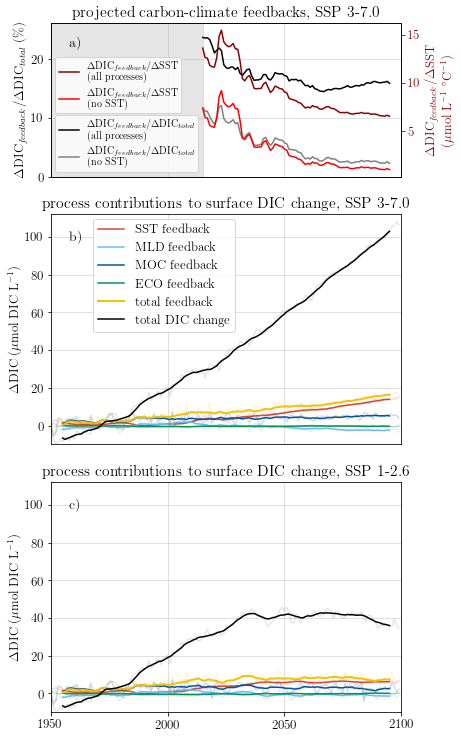

In [179]:
ymi = 0; yma = 26


fact = 0.95
# Create a figure
fig = plt.figure(figsize=(7*fact, 11*fact))

# Create a GridSpec with 3 rows and 1 column
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 3, 3])

# Add subplots using the GridSpec layout
ax2 = fig.add_subplot(gs[0, 0])
ax4 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])

# Set titles for each subplot for clarity
###

ax4.plot(yrs, ts_T_effect_glodap_1B_cum, color = sst_col, alpha = 0.2)
ax4.plot(yrs, pad_avg(ts_T_effect_glodap_1B_cum), color = sst_col, label = 'SST feedback')
ax4.plot(yrs, ts_MLD_effect_glodap_1B_cum, color = mld_col, alpha = 0.2)
ax4.plot(yrs, pad_avg(ts_MLD_effect_glodap_1B_cum), color = mld_col, label = 'MLD feedback')
ax4.plot(yrs, ts_OT_effect_glodap_1B_cum, color = ot_col, alpha = 0.2 )
ax4.plot(yrs, pad_avg(ts_OT_effect_glodap_1B_cum), color = ot_col, label = 'MOC feedback')
ax4.plot(yrs, ts_ECO_effect_glodap_1B_cum, color = eco_col, alpha = 0.2 )
ax4.plot(yrs, pad_avg(ts_ECO_effect_glodap_1B_cum), color = eco_col, label = 'ECO feedback')
ts_tot_effect_1B_cum_glodap = ts_T_effect_glodap_1B_cum + ts_MLD_effect_glodap_1B_cum + \
ts_OT_effect_glodap_1B_cum + ts_ECO_effect_glodap_1B_cum
ts_tot_effect_1B_nosst_glodap = ts_MLD_effect_glodap_1B_cum + \
ts_OT_effect_glodap_1B_cum + ts_ECO_effect_glodap_1B_cum

ax4.plot(yrs, ts_tot_effect_1B_cum_glodap, color = tot_col, alpha = 0.2, linewidth = 1)
ax4.plot(yrs, pad_avg(ts_tot_effect_1B_cum_glodap), color = tot_col, linewidth = 2, label = 'total feedback')
ax4.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax4.plot(yrs, pad_avg(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'total DIC change')

ax3.plot(yrs, ts_T_effect_glodap_1A_cum, color = sst_col, alpha = 0.2)
ax3.plot(yrs, pad_avg(ts_T_effect_glodap_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax3.plot(yrs, ts_MLD_effect_glodap_1A_cum, color = mld_col, alpha = 0.2)
ax3.plot(yrs, pad_avg(ts_MLD_effect_glodap_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax3.plot(yrs, ts_OT_effect_glodap_1A_cum, color = ot_col, alpha = 0.2 )
ax3.plot(yrs, pad_avg(ts_OT_effect_glodap_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax3.plot(yrs, ts_ECO_effect_glodap_1A_cum, color = eco_col, alpha = 0.2 )
ax3.plot(yrs, pad_avg(ts_ECO_effect_glodap_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_glodap_1A_cum + ts_MLD_effect_glodap_1A_cum + \
ts_OT_effect_glodap_1A_cum + ts_ECO_effect_glodap_1A_cum
ax3.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax3.plot(yrs, pad_avg(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax3.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax3.plot(yrs, pad_avg(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')

####### code for proportions!!!
glodap_prop = ts_tot_effect_1B_cum_glodap/ts_DIC_effect_medusa_1B_cum
glodap_propc = pad_avg(glodap_prop,sot)*100
ax2.plot(yrs,glodap_propc, color = 'k', label = '$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ \n (all processes)')
glodap_nosst_prop = ts_tot_effect_1B_nosst_glodap/ts_DIC_effect_medusa_1B_cum
glodap_nosst_propc = pad_avg(glodap_nosst_prop,sot)*100
ax2.plot(yrs,glodap_nosst_propc, color = 'grey', label = '$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ \n (no SST)')


axs2b = ax2.twinx()
dicpert = ts_tot_effect_1B_cum_glodap/sst_1B_eff_cum
dicpertc = pad_avg(dicpert,sot)
ax2.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
axs2b.plot(yrs,dicpertc, color ='darkred',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (all processes)')

dicpert_nosst = ts_tot_effect_1B_nosst_glodap/sst_1B_eff_cum
dicpertcs = pad_avg(dicpert_nosst,sot)
ax2.set_ylim([ymi,yma])
axs2b.plot(yrs,dicpertcs, color ='red',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (no SST)')



#axs2b.set_ylim([35,100])
axs2b.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs2b.tick_params(axis='y', colors='darkred')
axs2b.yaxis.label.set_color('darkred')


####### code for proportions!!!


ax2.set_xlim([1950,2100])
ax3.set_xlim([1950,2100])
ax4.set_xlim([1950,2100])
ax2.set_xticks(np.arange(1950,2150,50))
ax3.set_xticks(np.arange(1950,2150,50))
ax4.set_xticks(np.arange(1950,2150,50))
ax2.set_xticklabels([])
ax4.set_xticklabels([])
ax2.tick_params(axis='x', colors='red', size=0.1)
ax4.tick_params(axis='x', colors='red', size=0.1)

ax4.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax3.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax2.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ ($\%$)')

ax4.grid(alpha = 0.5)
ax2.grid(alpha = 0.5)
ax3.grid(alpha = 0.5)

ax2.set_title('projected carbon-climate feedbacks, SSP 3-7.0')
ax3.set_title('process contributions to surface DIC change, SSP 1-2.6')
ax4.set_title('process contributions to surface DIC change, SSP 3-7.0')

fs = 14
ax2.text(0.05, 0.85, 'a)', fontsize=fs, fontweight='bold', transform=ax2.transAxes)
ax4.text(0.05, 0.89,  'b)', fontsize=fs, fontweight='bold', transform=ax4.transAxes)#nsform=fig.transFigure)
ax3.text(0.05, 0.89, 'c)', fontsize=fs, fontweight='bold', transform=ax3.transAxes)

ax4.legend(loc = [0.12,0.49])

ax2.tick_params(axis='x', colors='red', size=0.1)
ax4.tick_params(axis='x', colors='red', size=0.1)

# Adjust layout
plt.tight_layout()

ax4.set_ylim([-10,112])
ax3.set_ylim([-10,112])

ax2.legend(loc = [0.01,0.032], fontsize = 10, )
axs2b.legend(loc = [0.01,0.412], fontsize = 10, ) #red lines

# Display the plot
plt.show()
fig.savefig(f'./figs/fig5_feedbacksfrom{sot}.png')

# sup fig

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:131: Ru

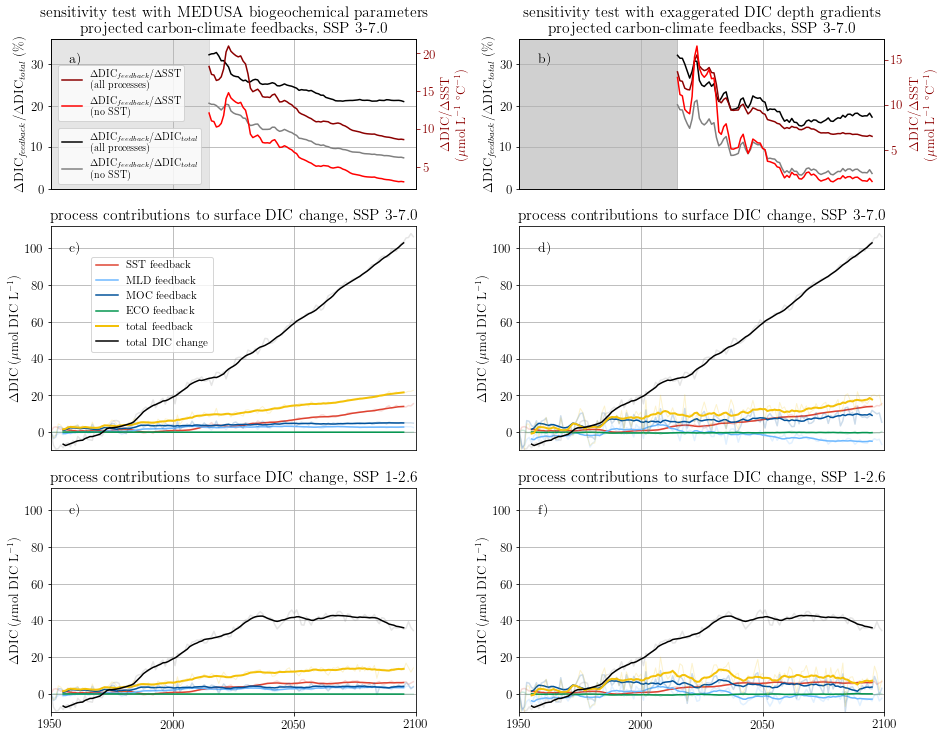

In [180]:
ymi = 0; yma = 36

#sot = yrstart-1950
fig = plt.figure(figsize=(14*fact, 11*fact))

# Create a GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 3, 3])

# Add subplots using the GridSpec layout
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

# Set titles for each subplot for clarity
ax3.set_title('aRow 2, Col 1 (Same height as Row 3)')
ax3.plot(yrs, ts_T_effect_medusa_1B_cum, color = sst_col, alpha = 0.2)
ax3.plot(yrs, pad_avg(ts_T_effect_medusa_1B_cum), color = sst_col, label = 'SST feedback')
ax3.plot(yrs, ts_MLD_effect_medusa_1B_cum, color = mld_col, alpha = 0.2)
ax3.plot(yrs, pad_avg(ts_MLD_effect_medusa_1B_cum), color = mld_col, label = 'MLD feedback')
ax3.plot(yrs, ts_OT_effect_medusa_1B_cum, color = ot_col, alpha = 0.2 )
ax3.plot(yrs, pad_avg(ts_OT_effect_medusa_1B_cum), color = ot_col, label = 'MOC feedback')
ax3.plot(yrs, ts_ECO_effect_medusa_1B_cum, color = eco_col, alpha = 0.2 )
ax3.plot(yrs, pad_avg(ts_ECO_effect_medusa_1B_cum), color = eco_col, label = 'ECO feedback')
ts_tot_effect_1B_cum_medusa = ts_T_effect_medusa_1B_cum + ts_MLD_effect_medusa_1B_cum + \
ts_OT_effect_medusa_1B_cum + ts_ECO_effect_medusa_1B_cum
ts_tot_effect_1B_nosst_medusa = ts_MLD_effect_medusa_1B_cum + \
ts_OT_effect_medusa_1B_cum + ts_ECO_effect_medusa_1B_cum

ax3.plot(yrs, ts_tot_effect_1B_cum_medusa, color = tot_col, alpha = 0.2, linewidth = 1)
ax3.plot(yrs, pad_avg(ts_tot_effect_1B_cum_medusa), color = tot_col, linewidth = 2, label = 'total feedback')
ax3.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax3.plot(yrs, pad_avg(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'total DIC change')

ax5.set_title('aRow 3, Col 1 (Same height as Row 2)')
ax5.plot(yrs, ts_T_effect_medusa_1A_cum, color = sst_col, alpha = 0.2)
ax5.plot(yrs, pad_avg(ts_T_effect_medusa_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax5.plot(yrs, ts_MLD_effect_medusa_1A_cum, color = mld_col, alpha = 0.2)
ax5.plot(yrs, pad_avg(ts_MLD_effect_medusa_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax5.plot(yrs, ts_OT_effect_medusa_1A_cum, color = ot_col, alpha = 0.2 )
ax5.plot(yrs, pad_avg(ts_OT_effect_medusa_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax5.plot(yrs, ts_ECO_effect_medusa_1A_cum, color = eco_col, alpha = 0.2 )
ax5.plot(yrs, pad_avg(ts_ECO_effect_medusa_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_medusa_1A_cum + ts_MLD_effect_medusa_1A_cum + \
ts_OT_effect_medusa_1A_cum + ts_ECO_effect_medusa_1A_cum
ax5.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax5.plot(yrs, pad_avg(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax5.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax5.plot(yrs, pad_avg(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')

ax4.set_title('Row 2, Col 2 (Same height as Row 3)')
ax4.plot(yrs, ts_T_effect_glodapvul_1B_cum, color = sst_col, alpha = 0.2)
ax4.plot(yrs, pad_avg(ts_T_effect_glodapvul_1B_cum), color = sst_col, label = 'SST')
ax4.plot(yrs, ts_MLD_effect_glodapvul_1B_cum, color = mld_col, alpha = 0.2)
ax4.plot(yrs, pad_avg(ts_MLD_effect_glodapvul_1B_cum), color = mld_col, label = 'MLD')
ax4.plot(yrs, ts_OT_effect_glodapvul_1B_cum, color = ot_col, alpha = 0.2 )
ax4.plot(yrs, pad_avg(ts_OT_effect_glodapvul_1B_cum), color = ot_col, label = 'MOC')
ax4.plot(yrs, ts_ECO_effect_glodapvul_1B_cum, color = eco_col, alpha = 0.2 )
ax4.plot(yrs, pad_avg(ts_ECO_effect_glodapvul_1B_cum), color = eco_col, label = 'ECO')
ts_tot_effect_1B_cum_glodapvul = ts_T_effect_glodapvul_1B_cum + ts_MLD_effect_glodapvul_1B_cum + \
ts_OT_effect_glodapvul_1B_cum + ts_ECO_effect_glodapvul_1B_cum
ts_tot_effect_1B_nosst_glodapvul = ts_MLD_effect_glodapvul_1B_cum + \
ts_OT_effect_glodapvul_1B_cum + ts_ECO_effect_glodapvul_1B_cum

ax4.plot(yrs, ts_tot_effect_1B_cum_glodapvul, color = tot_col, alpha = 0.2, linewidth = 1)
ax4.plot(yrs, pad_avg(ts_tot_effect_1B_cum_glodapvul), color = tot_col, linewidth = 2, label = 'total')
ax4.plot(yrs, ts_DIC_effect_medusa_1B_cum, color = 'grey', alpha = 0.2,  )
ax4.plot(yrs, pad_avg(ts_DIC_effect_medusa_1B_cum), 'k', alpha = 1, label = 'surface DIC change')

ax6.set_title('Row 3, Col 2 (Same height as Row 2)')
ax6.plot(yrs, ts_T_effect_glodapvul_1A_cum, color = sst_col, alpha = 0.2)
ax6.plot(yrs, pad_avg(ts_T_effect_glodapvul_1A_cum), color = sst_col, label = 'DIC change due to SST')
ax6.plot(yrs, ts_MLD_effect_glodapvul_1A_cum, color = mld_col, alpha = 0.2)
ax6.plot(yrs, pad_avg(ts_MLD_effect_glodapvul_1A_cum), color = mld_col, label = 'DIC change due to MLD')
ax6.plot(yrs, ts_OT_effect_glodapvul_1A_cum, color = ot_col, alpha = 0.2 )
ax6.plot(yrs, pad_avg(ts_OT_effect_glodapvul_1A_cum), color = ot_col, label = 'DIC change due to MOC')
ax6.plot(yrs, ts_ECO_effect_glodapvul_1A_cum, color = eco_col, alpha = 0.2 )
ax6.plot(yrs, pad_avg(ts_ECO_effect_glodapvul_1A_cum), color = eco_col, label = 'DIC change cumulative')
ts_tot_effect_1A_cum = ts_T_effect_glodapvul_1A_cum + ts_MLD_effect_glodapvul_1A_cum + \
ts_OT_effect_glodapvul_1A_cum + ts_ECO_effect_glodapvul_1A_cum

ax6.plot(yrs, ts_tot_effect_1A_cum, color = tot_col, alpha = 0.2, linewidth = 1)
ax6.plot(yrs, pad_avg(ts_tot_effect_1A_cum), color = tot_col, linewidth = 2)
ax6.plot(yrs, ts_DIC_effect_medusa_1A_cum, color = 'grey', alpha = 0.2,  label = 'DIC change medusa, 1A')
ax6.plot(yrs, pad_avg(ts_DIC_effect_medusa_1A_cum), 'k', alpha = 1, label = 'DIC change cumulative, 1A')


####### code for proportions!!!
####### code for proportions!!!
glodapvul_prop = ts_tot_effect_1B_cum_glodapvul/ts_DIC_effect_medusa_1B_cum
glodapvul_propc = pad_avg(glodapvul_prop,sot)*100
ax2.plot(yrs,glodapvul_propc, color = 'k', label = 'all processes')
glodapvul_nosst_prop = ts_tot_effect_1B_nosst_glodapvul/ts_DIC_effect_medusa_1B_cum
glodapvul_nosst_propc = pad_avg(glodapvul_nosst_prop,sot)*100
ax2.plot(yrs,glodapvul_nosst_propc, color = 'grey', label = 'no SST')


axs2b = ax2.twinx()
dicpert = ts_tot_effect_1B_cum_glodap/sst_1B_eff_cum
dicpertc = pad_avg(dicpert,sot)
ax2.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
axs2b.plot(yrs,dicpertc, color ='darkred',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (all processes)')

dicpert_nosst = ts_tot_effect_1B_nosst_glodapvul/sst_1B_eff_cum
dicpertcs = pad_avg(dicpert_nosst,sot)
ax2.set_ylim([ymi,yma])
axs2b.plot(yrs,dicpertcs, color ='red',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (no SST)')



ax2.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
#axs2b.set_ylim([35,100])
axs2b.set_ylabel('$\Delta$DIC/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs2b.tick_params(axis='y', colors='darkred')
axs2b.yaxis.label.set_color('darkred')
####### code for proportions!!!

####### code for proportions!!!
medusa_prop = ts_tot_effect_1B_cum_medusa/ts_DIC_effect_medusa_1B_cum
medusa_propc = pad_avg(medusa_prop,sot)*100
ax1.plot(yrs,medusa_propc, color = 'k', label = '$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ \n (all processes)')
medusa_nosst_prop = ts_tot_effect_1B_nosst_medusa/ts_DIC_effect_medusa_1B_cum
medusa_nosst_propc = pad_avg(medusa_nosst_prop,sot)*100
ax1.plot(yrs,medusa_nosst_propc, color = 'grey', label = '$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ \n (no SST)')

axs1b = ax1.twinx()
dicpert = ts_tot_effect_1B_cum_medusa/sst_1B_eff_cum
dicpertc = pad_avg(dicpert,sot)
dicpert_nosst = ts_tot_effect_1B_nosst_medusa/sst_1B_eff_cum
dicpertcs = pad_avg(dicpert_nosst,sot)
axs1b.plot(yrs,dicpertc, color ='darkred',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (all processes)')
axs1b.plot(yrs,dicpertcs, color ='red',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (no SST)')

ax1.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
axs1b.set_ylabel('$\Delta$DIC/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='darkred')
axs1b.tick_params(axis='y', colors='darkred')
axs1b.yaxis.label.set_color('darkred')



ax1.set_xlim([1950,2100])
ax2.set_xlim([1950,2100])
ax1.set_ylim([ymi,yma])
ax2.set_ylim([ymi,yma])
ax3.set_xlim([1950,2100])
ax4.set_xlim([1950,2100])
ax5.set_xlim([1950,2100])
ax6.set_xlim([1950,2100])


ax1.text(0.05, 0.85, 'a)', fontsize=fs, fontweight='bold', transform=ax1.transAxes)
ax2.text(0.05, 0.85, 'b)', fontsize=fs, fontweight='bold', transform=ax2.transAxes)
ax3.text(0.05, 0.89, 'c)', fontsize=fs, fontweight='bold', transform=ax3.transAxes)
ax4.text(0.05, 0.89, 'd)', fontsize=fs, fontweight='bold', transform=ax4.transAxes)
ax5.text(0.05, 0.89, 'e)', fontsize=fs, fontweight='bold', transform=ax5.transAxes)
ax6.text(0.05, 0.89, 'f)', fontsize=fs, fontweight='bold', transform=ax6.transAxes)

ax3.legend(loc = [0.11,0.44], fontsize = 11)
ax3.set_ylim([-10,112])
ax4.set_ylim([-10,112])
ax5.set_ylim([-10,112])
ax6.set_ylim([-10,112])

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])


###
ax1.set_xlim([1950,2100])
ax2.set_xlim([1950,2100])
ax3.set_xlim([1950,2100])
ax4.set_xlim([1950,2100])
ax5.set_xlim([1950,2100])
ax6.set_xlim([1950,2100])
ax1.set_xticks(np.arange(1950,2150,50))
ax2.set_xticks(np.arange(1950,2150,50))
ax3.set_xticks(np.arange(1950,2150,50))
ax4.set_xticks(np.arange(1950,2150,50))
ax5.set_xticks(np.arange(1950,2150,50))
ax6.set_xticks(np.arange(1950,2150,50))
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax1.tick_params(axis='x', colors='red', size=0.1)
ax2.tick_params(axis='x', colors='red', size=0.1)
ax3.tick_params(axis='x', colors='red', size=0.1)
ax4.tick_params(axis='x', colors='red', size=0.1)
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
ax5.grid()
ax6.grid()



ax2.set_title('sensitivity test with exaggerated DIC depth gradients \n projected carbon-climate feedbacks, SSP 3-7.0')
ax4.set_title('process contributions to surface DIC change, SSP 3-7.0')
ax6.set_title('process contributions to surface DIC change, SSP 1-2.6')

ax1.set_title('sensitivity test with MEDUSA biogeochemical parameters \n projected carbon-climate feedbacks, SSP 3-7.0')
ax3.set_title('process contributions to surface DIC change, SSP 3-7.0')
ax5.set_title('process contributions to surface DIC change, SSP 1-2.6')

ax4.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax3.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax5.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax6.set_ylabel('$\Delta$DIC ($\mu$mol DIC L$^{-1}$)')
ax1.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ ($\%$)')
ax2.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ ($\%$)')


plt.tight_layout()

ax1.legend(loc = [0.018,0.03], fontsize = 10)
axs1b.legend(loc = [0.018,0.45], fontsize = 10)
# Display the plot
plt.show()

## plenary figure

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


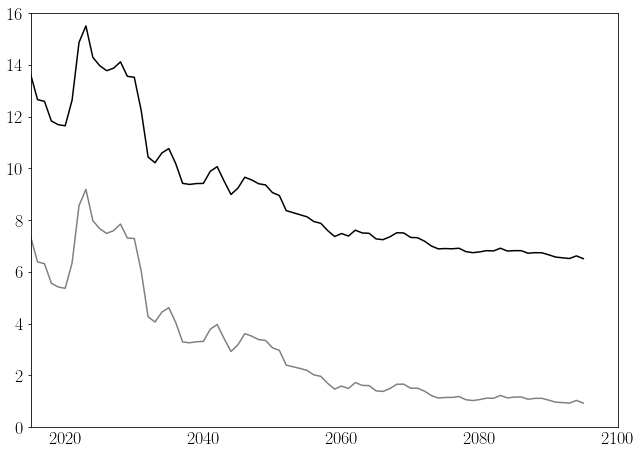

/gpfs/home/mep22dku/.conda/envs/swamp2/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6


In [181]:
ymi = 0; yma = 16

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fact = 1.3
# Create a figure
fig, ax2 = plt.subplots(figsize=(7*fact, 5*fact))


dicpert = ts_tot_effect_1B_cum_glodap/sst_1B_eff_cum
dicpertc = pad_avg(dicpert,sot)
ax2.fill_betweenx([-200, 200], 1950, sot, color='grey', alpha=0.2)
ax2.set_ylim([ymi,yma])
ax2.plot(yrs,dicpertc, color ='k',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (all processes)')

dicpert_nosst = ts_tot_effect_1B_nosst_glodap/sst_1B_eff_cum
dicpertcs = pad_avg(dicpert_nosst,sot)
ax2.set_ylim([ymi,yma])

ax2.plot(yrs,dicpertcs, color ='grey',label = '$\Delta$DIC$_{feedback}$/$\Delta$SST\n (no SST)')



#axs2b.set_ylim([35,100])
#ax2.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$SST \n ($\mu$mol L$^{-1}$ $^{\circ}$C$^{-1}$)', color='k', fontsize = 14)
ax2.tick_params(axis='y', colors='k')
ax2.yaxis.label.set_color('k')


####### code for proportions!!!


ax2.set_xlim([2015,2100])
ax2.set_xticks(np.arange(2020,2120,20))
ax2.set_yticks(np.arange(0,18,2))
ax2.set_yticklabels(np.arange(0,18,2),fontsize = 18)
ax2.set_xticklabels(np.arange(2020,2120,20),fontsize = 18)
ax2.tick_params(axis='x', colors='red', size=0.1)
#ax2.set_ylabel('$\Delta$DIC$_{feedback}$/$\Delta$DIC$_{total}$ ($\%$)')


#ax2.set_title('projected carbon-climate feedbacks, SSP 3-7.0', fontsize = 18)

ax2.tick_params(axis='x', colors='k', size=0.1)

# Adjust layout
plt.tight_layout()



#ax2.legend(loc = [0.01,0.032], fontsize = 10, )
#ax2.legend(loc = 'upper right', fontsize = 14, ) #red lines
#plt.legend(bbox_to_anchor = [1,1])#, fontsize = 14, ) #red lines

# Display the plot
plt.show()
#fig.savefig(f'./fig5_feedbacksfrom{sot}-03.png')
fig.savefig(f'./fig5_feedbacksfrom{sot}-04.jpg', dpi=300, quality=95)